# Three Body Problem: Neural Network Training

A simple neural network is trained to learn approximate solutions to the three body problem.<br>
Data is sampled from three body systems that are perturbed versions of the Sun-Earth-Jupiter system.

In [ ]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [ ]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style, range_inc
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_elts, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_data import combine_datasets_g3b, combine_datasets_solar
from sej_data import load_data_sej, make_datasets_sej, combine_datasets_sej
from sej_data import orb_elt_cov

from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import fit_model
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [3]:
# Set active GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1:2], 'GPU')

In [4]:
# Grow GPU memory (must be first operation in TF)
# gpu_grow_memory()

In [5]:
# Lightweight serialization
# fname = '../data/g3b/g3b_train.pickle'
fname = '../data/sej/sej_train.pickle'
vartbl = load_vartbl(fname)

In [6]:
# Set plot style
plot_style()

### Load Data for General Three Body Problem

In [7]:
# Description of datasets to be loaded
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1

In [8]:
# Configuration for loading data sets
# num_data_sets = 50
num_data_sets = 5
batch_size = 256
# num_gpus = 1
# full_batch_size = num_gpus * batch_size

# Set size of tiny data sets
n_traj_tiny = batch_size

# Set starting random seed
seed0 = 42

In [9]:
# Create a tiny data set with one batch of solar type orbits
ds_tiny_solar, _ , _ = \
    make_datasets_solar(n_traj=n_traj_tiny, vt_split=0.0, 
                        n_years=n_years, sample_freq=sample_freq,
                        batch_size=batch_size, seed=seed0)

Loaded data from ../data/g3b/1789961721.pickle.


W0822 14:37:42.390573 140287593961280 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
# Build combined solar data sets
# ds_solar_trn, ds_solar_val, ds_solar_tst = \
#     combine_datasets_solar(num_data_sets=num_data_sets, batch_size=batch_size, seed0=seed0)

### Load Data for Perturbed Sun-Earth-Jupiter System

In [11]:
# Orbital perturbation scales
scale_factor = 1.0
sd_q = scale_factor * np.array([0.00, 0.01, 0.05])
sd_v = sd_q

In [12]:
# Create a tiny data set with one batch of perturbed SEJ orbits
ds_tiny_sej, _ , _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=sd_q, sd_v=sd_v,
                      batch_size=batch_size, seed=seed0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1261268456.pickle.


In [13]:
# Create a tiny data set with the unperturbed SEJ system
ds_sej0, _, _ = \
    make_datasets_sej(n_traj=n_traj_tiny, vt_split=0.0, n_years=n_years, sample_freq=sample_freq,
                      sd_q=0.0, sd_v=0.0,
                      batch_size=batch_size, seed=0,
                      assemble_datasets=True)

Loaded data from ../data/sej/1521397475.pickle.


In [14]:
# Table of data sets keyed by scale factor
data_by_factor = dict()

In [60]:
# Build combined SEJ data sets with base scale factor
scale_factor = 1.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3977083274.pickle.


Loaded data from ../data/sej/2722950989.pickle.
Loaded data from ../data/sej/400724224.pickle.
Loaded data from ../data/sej/3353493630.pickle.
Loaded data from ../data/sej/3130373179.pickle.



In [61]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

***Choose Data Set for Analysis: Solar vs. SEJ***

In [62]:
# Alias ds_trn, ds_val, ds_tst to selected source

# The selected data type for this analysis
data_type = 'SEJ'

# # Tables mapping data type to tuple of data sets
# data_by_type = {
#     # 'solar': (ds_tiny_solar, ds_solar_trn, ds_solar_val, ds_solar_tst),
#     'SEJ': (ds_tiny_sej, ds_sej_trn, ds_sej_val, ds_sej_tst)
# }

# # Perform the aliasing
# ds_tiny, ds_trn, ds_val, ds_tst = data_by_type[data_type]

ds_tiny = ds_tiny_sej

### Create the Kepler-Jacobi Model as a Benchmark

In [18]:
model_kj = make_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0E-6),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0E4,
                'v0_rec': 1.0E4,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [20]:
# Compile the full mathematical model
model_kj.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [21]:
# Evaluate KJ model on unperturbed SEJ data set
model_kj.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [22]:
# Evaluate KJ model on tiny data set
model_kj.evaluate(ds_tiny)

1/1 [==============================] - 0s 115ms/step - loss: 6.8487e-05 - q_loss: 1.9837e-05 - v_loss: 1.9812e-05 - a_loss: 2.8838e-05 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 9.5866e-14 - P_loss: 3.8770e-14 - L_loss: 2.0161e-14


[6.848739576525986e-05,
 1.9836736e-05,
 1.9811845e-05,
 2.883841e-05,
 2.0670675e-14,
 1.9992044e-14,
 9.5865854e-14,
 3.8770395e-14,
 2.0161029e-14]

In [23]:
# Evaluate KJ model on full validation data
model_kj.evaluate(ds_val)

35/35 [==============================] - 5s 143ms/step - loss: 6.7929e-05 - q_loss: 1.9743e-05 - v_loss: 1.9718e-05 - a_loss: 2.8467e-05 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 9.5034e-14 - P_loss: 3.8634e-14 - L_loss: 2.0124e-14


[6.79291194371347e-05,
 1.9742967e-05,
 1.9718367e-05,
 2.8467404e-05,
 1.9458574e-14,
 1.8404181e-14,
 9.5034074e-14,
 3.8634403e-14,
 2.0123895e-14]

### Train the Neural Network Model

In [63]:
# Configuration for neural network model architecture
# hidden_sizes = []
hidden_sizes = [64, 16]
skip_layers = True

# Training configuration
learning_rate = 1.0E-7
kernel_reg = 1.0E-6
activity_reg = 0.0

In [64]:
# Build neural network model
model_nn = make_model_g3b_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers, 
                             kernel_reg=kernel_reg, activity_reg=activity_reg,
                             traj_size=traj_size, batch_size=batch_size)

In [65]:
# model_nn.summary()

In [66]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
# optimizer = keras.optimizers.Adadelta()

In [67]:
# Compile the NN model
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [68]:
# Evaluate the NN model on the unperturbed orbit
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 6.7071e-05 - q_loss: 1.9321e-05 - v_loss: 1.9308e-05 - a_loss: 2.8442e-05 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 6.6203e-14 - P_loss: 3.6133e-14 - L_loss: 1.1413e-14


[6.707102875225246e-05,
 1.9320656e-05,
 1.9308249e-05,
 2.844182e-05,
 9.793443e-15,
 2.0469324e-14,
 6.620291e-14,
 3.6132582e-14,
 1.1412751e-14]

In [29]:
# Evaluate the NN model on the tiny data set
# model_nn.evaluate(ds_tiny)

In [30]:
# Evaluate the NN model on the full validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 5s 136ms/step - loss: 6.7929e-05 - q_loss: 1.9743e-05 - v_loss: 1.9718e-05 - a_loss: 2.8467e-05 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 9.5034e-14 - P_loss: 3.8634e-14 - L_loss: 2.0124e-14


[6.79291194371347e-05,
 1.9742967e-05,
 1.9718367e-05,
 2.8467404e-05,
 1.9458574e-14,
 1.8404181e-14,
 9.5034074e-14,
 3.8634403e-14,
 2.0123895e-14]

In [69]:
# Compare this to math model - should be the same before training
# model_math.evaluate(ds_val)

# Hard coded baseline losses
loss_baseline_list = \
[6.79291194371347e-05,
 1.9742967e-05,
 1.9718367e-05,
 2.8467404e-05,
 1.9458574e-14,
 1.8404181e-14,
 9.5034074e-14,
 3.8634403e-14,
 2.0123895e-14]

# Baseline position loss
q_loss_baseline = loss_baseline_list[1]

# Table of baseline losses
keys = ['loss', 'q_loss', 'v_loss', 'a_loss', 'q0_rec_loss', 'v0_rec_loss', 'H_loss', 'P_loss', 'L_loss']
loss_baseline = {key: loss_baseline_list[i] for i, key in enumerate(keys)}
# Set dummy batch_num and time
loss_baseline['batch_num'] = 0
loss_baseline['time'] = 0.0

# Initialize history before training
hist0 = {key: np.array([val], dtype=np.float32) for key, val in loss_baseline.items()}

# Review baseline loss table
# loss_baseline

In [70]:
# Set up training

# Suffix to the model name reflects layer sizes
suffix = '_'.join(str(sz) for sz in hidden_sizes)

# The model code is g3b or sej based on type of data
if data_type == 'solar':   
    model_code = 'g3b'
elif data_type == 'SEJ':
    model_code = 'sej'
# The folder is the same as the model code
folder = model_code
model_name = f'model_{model_code}_nn_{suffix}'

# Apply new model name to model_nn instance
model_nn._name = model_name
# H5 file with model weights
model_h5 = f'../models/{folder}/{model_name}.h5'
hist_name = model_name.replace('model_', 'hist_')
epochs = 1
save_freq = 'epoch'

# Status
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_nn.name = model_sej_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16.h5
hist_name = hist_sej_nn_64_16


### Train on Unperturbed Model (ds_sej0)

In [ ]:
model_nn.evaluate(ds_sej0)

In [72]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    for i in range(5):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_sej0, 
                         epochs=10,
                         save_freq=save_freq,
                         prev_history = hist0, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16 from ../models/sej/model_sej_nn_64_16.h5.


In [73]:
model_nn.evaluate(ds_sej0)

1/1 [==============================] - 2s 2s/step - loss: 1.0659e-06 - q_loss: 1.0573e-07 - v_loss: 1.0272e-07 - a_loss: 8.5428e-07 - q0_rec_loss: 9.7934e-15 - v0_rec_loss: 2.0469e-14 - H_loss: 7.7287e-12 - P_loss: 3.8356e-14 - L_loss: 2.0965e-09


[1.0658612836778047e-06,
 1.0572905e-07,
 1.02718765e-07,
 8.542795e-07,
 9.793443e-15,
 2.0469324e-14,
 7.7287335e-12,
 3.8356383e-14,
 2.0964548e-09]

In [75]:
# Plot the loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Tiny Data Set

In [76]:
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    for i in range(5):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_tiny, 
                         epochs=10,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Loaded model_sej_nn_64_16 from ../models/sej/model_sej_nn_64_16.h5.


In [77]:
model_nn.evaluate(ds_tiny)

1/1 [==============================] - 2s 2s/step - loss: 1.3124e-06 - q_loss: 1.2219e-07 - v_loss: 1.1519e-07 - a_loss: 1.0720e-06 - q0_rec_loss: 2.0671e-14 - v0_rec_loss: 1.9992e-14 - H_loss: 4.3381e-12 - P_loss: 3.9435e-14 - L_loss: 1.8543e-09


[1.3123958524374757e-06,
 1.2219174e-07,
 1.15188186e-07,
 1.0720236e-06,
 2.0670675e-14,
 1.9992044e-14,
 4.3380638e-12,
 3.9434608e-14,
 1.8543136e-09]

In [78]:
# Plot the loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 1.0

In [85]:
# Scale factor
scale_factor = 1.0

# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 2
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
# print(f'model_nn.name = {model_nn.name}')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_name = model_sej_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_sf_1.h5
hist_name = hist_sej_nn_64_16_sf_1


In [86]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    hist = hist0
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)
    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16 from ../models/sej/model_sej_nn_64_16_sf_1.h5. Fitting...
*** Training loop   1 *** - 2019-08-22 15:14:25
194/195 [============================>.] - ETA: 0s - loss: 1.1721e-06 - q_loss: 1.5132e-07 - v_loss: 1.4465e-07 - a_loss: 8.7501e-07 - q0_rec_loss: 1.9386e-14 - v0_rec_loss: 1.8410e-14 - H_loss: 2.0322e-13 - P_loss: 3.9272e-14 - L_loss: 6.4812e-11
Epoch 0001; loss 1.17e-06; elapsed 0:00:55
195/195 [==============================] - 47s 240ms/step - loss: 1.1728e-06 - q_loss: 1.5141e-07 - v_loss: 1.4474e-07 - a_loss: 8.7548e-07 - q0_rec_loss: 1.9384e-14 - v0_rec_loss: 1.8411e-14 - H_loss: 2.0271e-13 - P_loss: 3.9271e-14 - L_loss: 6.4479e-11
*** Training loop   2 *** - 2019-08-22 15:15:21
194/195 [============================>.] - ETA: 0s - loss: 1.1721e-06 - q_loss: 1.5131e-07 - v_loss: 1.4463e-07 - a_loss: 8.7507e-07 - q0_rec_loss: 1.9386e-14 - v0_rec_loss: 1.8410e-14 - H_loss: 1.0510e-13 - P_loss: 3.9271e-14 - L_loss: 3.3485e-14
Epoch 0001; loss 1

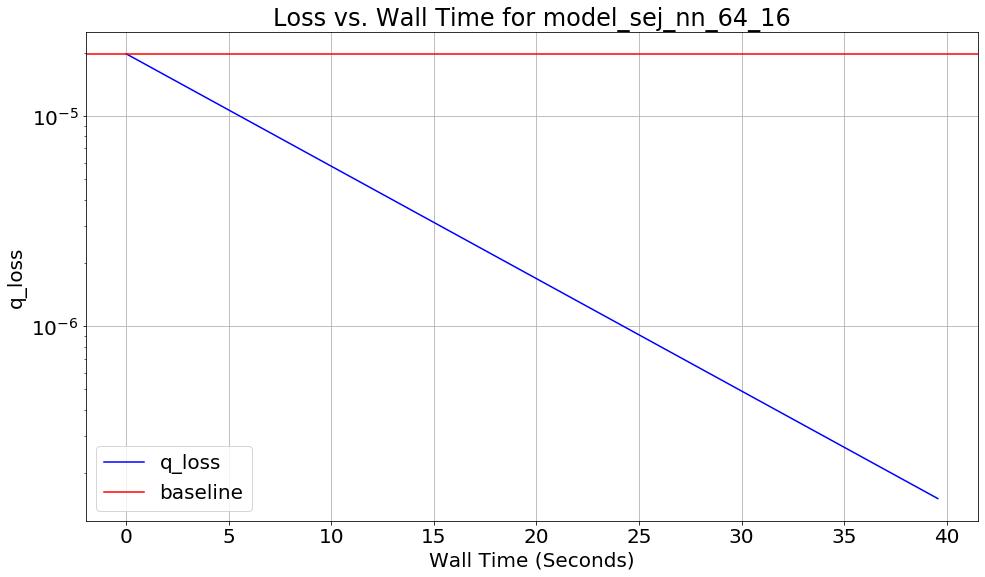

In [87]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

In [37]:
# Plot the total loss
# fig, ax = plot_loss_hist(hist=hist, model_name=model_nn.name, key='loss')

In [38]:
# Evaluate the trained model on the training data
# model_nn.evaluate(ds_trn)

In [88]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 7s 203ms/step - loss: 1.1553e-06 - q_loss: 1.4201e-07 - v_loss: 1.3520e-07 - a_loss: 8.7699e-07 - q0_rec_loss: 1.9459e-14 - v0_rec_loss: 1.8404e-14 - H_loss: 1.0454e-13 - P_loss: 3.9267e-14 - L_loss: 3.2125e-14


[1.1553001221337971e-06,
 1.4201174e-07,
 1.3519517e-07,
 8.7698623e-07,
 1.9458574e-14,
 1.8404181e-14,
 1.0454285e-13,
 3.926709e-14,
 3.2125256e-14]

In [40]:
# Evaluate the trained model on the test data
# model_nn.evaluate(ds_tst)

In [41]:
# hist['q_loss']

### Describe Covariance of Dataset Orbital Elements

In [42]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [43]:
# List of orbital elements in the cov matrix
elt_names = ['a1', 'a2', 'e1', 'e2', 'inc1', 'inc2', 'Omega1', 'Omega2', 'omega1', 'omega2', 'f1', 'f2']
# limit to the interesting ones
elt_names = elt_names[0:6]

In [44]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.021019
SD of a2     = 0.228333
SD of e1     = 0.009339
SD of e2     = 0.030154
SD of inc1   = 0.005925
SD of inc2   = 0.011256


### Train on Full Data Set with Perturbation Scale Factor = 2.0

In [89]:
# Build combined SEJ data sets with scale factor = 2
scale_factor = 2.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/3461170694.pickle.


Loaded data from ../data/sej/2165100737.pickle.
Loaded data from ../data/sej/883076748.pickle.
Loaded data from ../data/sej/3835854834.pickle.
Loaded data from ../data/sej/2580908983.pickle.



In [90]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [91]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [92]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.042134
SD of a2     = 0.472072
SD of e1     = 0.015736
SD of e2     = 0.050770
SD of inc1   = 0.011849
SD of inc2   = 0.020815


In [93]:
# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 5
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
# print(f'model_nn.name = {model_nn.name}')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_name = model_sej_nn_64_16
model_h5 = ../models/sej/model_sej_nn_64_16_sf_2.h5
hist_name = hist_sej_nn_64_16_sf_2


In [94]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = hist0
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16 from ../models/sej/model_sej_nn_64_16_sf_2.h5. Fitting...
*** Training loop   1 *** - 2019-08-22 15:21:58
194/195 [============================>.] - ETA: 0s - loss: 1.2957e-06 - q_loss: 2.4318e-07 - v_loss: 2.2324e-07 - a_loss: 8.2812e-07 - q0_rec_loss: 2.2892e-14 - v0_rec_loss: 2.2396e-14 - H_loss: 1.1491e-13 - P_loss: 3.8723e-14 - L_loss: 5.1462e-14
Epoch 0001; loss 1.30e-06; elapsed 0:00:51
195/195 [==============================] - 41s 212ms/step - loss: 1.2957e-06 - q_loss: 2.4346e-07 - v_loss: 2.2351e-07 - a_loss: 8.2755e-07 - q0_rec_loss: 2.2880e-14 - v0_rec_loss: 2.2382e-14 - H_loss: 1.1496e-13 - P_loss: 3.8724e-14 - L_loss: 5.1503e-14
*** Training loop   2 *** - 2019-08-22 15:22:49
194/195 [============================>.] - ETA: 0s - loss: 1.2874e-06 - q_loss: 2.3962e-07 - v_loss: 2.2010e-07 - a_loss: 8.2644e-07 - q0_rec_loss: 2.2892e-14 - v0_rec_loss: 2.2396e-14 - H_loss: 1.1981e-13 - P_loss: 3.8729e-14 - L_loss: 4.7274e-14
Epoch 0001; loss 1

In [95]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

35/35 [==============================] - 4s 128ms/step - loss: 1.3257e-06 - q_loss: 1.8601e-07 - v_loss: 1.6480e-07 - a_loss: 9.7363e-07 - q0_rec_loss: 2.2697e-14 - v0_rec_loss: 2.2183e-14 - H_loss: 9.8126e-12 - P_loss: 3.8719e-14 - L_loss: 3.5624e-11


[1.325742781383659e-06,
 1.8601482e-07,
 1.64801e-07,
 9.736275e-07,
 2.269701e-14,
 2.2183288e-14,
 9.812567e-12,
 3.8718872e-14,
 3.5624486e-11]

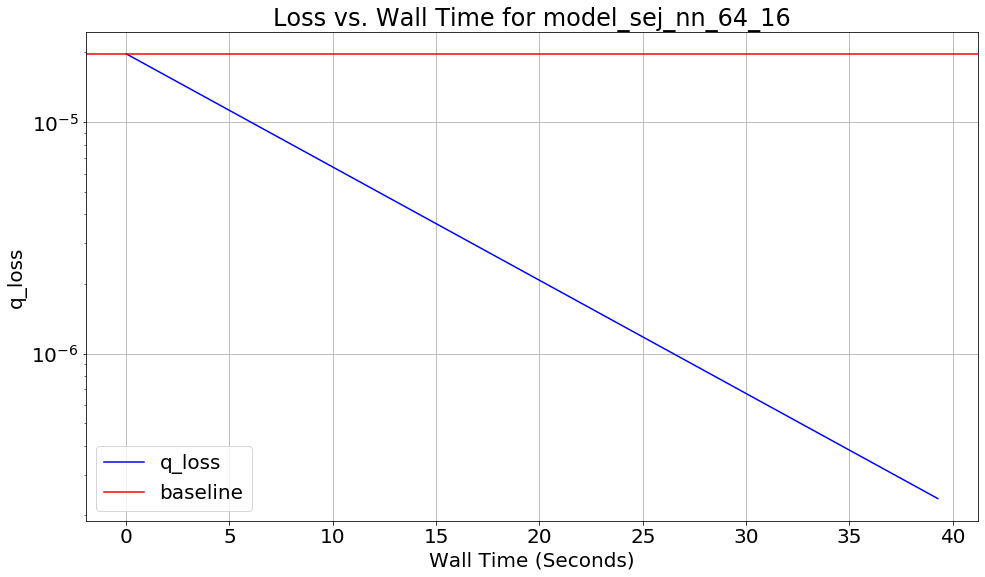

In [96]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 4.0

In [98]:
# Build combined SEJ data sets with scale factor = 4
scale_factor = 4.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

Loaded data from ../data/sej/109948493.pickle.


Loaded data from ../data/sej/1238120586.pickle.
Loaded data from ../data/sej/4234299079.pickle.
Loaded data from ../data/sej/744658873.pickle.
Loaded data from ../data/sej/1360356348.pickle.



In [99]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [100]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [101]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

SD of a1     = 0.085013
SD of a2     = 1.119090
SD of e1     = 0.028830
SD of e2     = 0.093952
SD of inc1   = 0.023712
SD of inc2   = 0.039768


In [108]:
# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 10
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name model instance to include scale factor
model_nn._name = f'{model_name}_sf_{sfi}'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
print(f'model_name = {model_name}')
print(f'model_nn.name = {model_nn.name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

model_name = model_sej_nn_64_16
model_nn.name = model_sej_nn_64_16_sf_4
model_h5 = ../models/sej/model_sej_nn_64_16_sf_4.h5
hist_name = hist_sej_nn_64_16_sf_4


In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = hist0
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

Unable to load model_sej_nn_64_16 from ../models/sej/model_sej_nn_64_16_sf_4.h5. Fitting...
*** Training loop   1 *** - 2019-08-22 15:45:16
194/195 [============================>.] - ETA: 0s - loss: 1.5664e-04 - q_loss: 5.1974e-05 - v_loss: 5.1659e-05 - a_loss: 5.3007e-05 - q0_rec_loss: 2.5150e-14 - v0_rec_loss: 2.5211e-14 - H_loss: 3.3178e-11 - P_loss: 3.6827e-14 - L_loss: 8.4663e-10  ETA: 10s - loss: 5.8572e-05 - q_loss: 1.9400e-05 - v_loss: 1.9077e-05 - a_loss: 2.0093e-05 - q0_rec_loss: 2.5095e-14 - v0_rec_loss: 2.5215e-14 - H_loss: 2
Epoch 0001; loss 1.56e-04; elapsed 0:00:53
195/195 [==============================] - 44s 224ms/step - loss: 1.5590e-04 - q_loss: 5.1727e-05 - v_loss: 5.1413e-05 - a_loss: 5.2753e-05 - q0_rec_loss: 2.5167e-14 - v0_rec_loss: 2.5229e-14 - H_loss: 3.3138e-11 - P_loss: 3.6827e-14 - L_loss: 8.4594e-10
*** Training loop   2 *** - 2019-08-22 15:46:09
194/195 [============================>.] - ETA: 0s - loss: 1.5664e-04 - q_loss: 5.1976e-05 - v_loss: 5.1657e-0

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 8.0

In [ ]:
# Build combined SEJ data sets with scale factor = 8
scale_factor = 8.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 10
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name model instance to include scale factor
model_nn._name = f'{model_name}_sf_{sfi}'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
# print(f'model_nn.name = {model_nn.name}')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = hist0
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 16.0

In [ ]:
# Build combined SEJ data sets with scale factor = 4
scale_factor = 16.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 10
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name model instance to include scale factor
model_nn._name = f'{model_name}_sf_{sfi}'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
# print(f'model_nn.name = {model_nn.name}')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = hist0
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)

### Train on Full Data Set with Perturbation Scale Factor = 32.0

In [ ]:
# Build combined SEJ data sets with scale factor = 32
scale_factor = 32.0
ds_trn, ds_val, ds_tst = \
    combine_datasets_sej(num_data_sets=num_data_sets, batch_size=batch_size, 
                         seed0=seed0, scale_factor=scale_factor)

In [ ]:
# Update data by scale factor
data_by_factor[scale_factor] = (ds_trn, ds_val, ds_tst)

In [ ]:
# Compute covariance matrix of orbital elements
cov = orb_elt_cov(ds_val)

In [ ]:
# Display standard deviations of orbital elements
sds = np.sqrt(np.diag(cov))
for i, elt_name in enumerate(elt_names):
    sd = sds[i]
    print(f'SD of {elt_name:6} = {sd:8.6f}')

In [ ]:
# Data for this scale factor
ds_trn, ds_val, ds_tst = data_by_factor[scale_factor]

# Number of epochs to train
num_batches = 10
epochs=1

# Integer scale factor
sfi = int(scale_factor)

# H5 file with model weights for this scale factor
model_h5 = f'../models/{folder}/{model_name}_sf_{sfi}.h5'

# Name model instance to include scale factor
model_nn._name = f'{model_name}_sf_{sfi}'

# Name of the history
hist_name = f'hist_{model_code}_nn_{suffix}_sf_{sfi}'

save_freq = 'epoch'

# Status
# print(f'model_nn.name = {model_nn.name}')
print(f'model_name = {model_name}')
print(f'model_h5 = {model_h5}')
print(f'hist_name = {hist_name}')

In [ ]:
# Attempt to load model or train on selected number of epochs
try:
    model_nn.load_weights(model_h5)
    model_nn.compile(loss=loss, optimizer=optimizer, metrics=metrics, loss_weights=loss_weights)
    hist = vartbl[hist_name]
    print(f'Loaded {model_name} from {model_h5}.')
except:
    print(f'Unable to load {model_name} from {model_h5}. Fitting...')
    for i in range_inc(num_batches):
        ts = datetime.datetime.now()
        st = ts.strftime('%Y-%m-%d %H:%M:%S')
        print(f'*** Training loop {i:3} *** - {st}')
        hist = hist0
        hist = fit_model(model=model_nn,
                         folder=folder,
                         ds=ds_trn, 
                         epochs=epochs,
                         save_freq=save_freq,
                         prev_history = hist, 
                         batch_num=i)    
    vartbl[hist_name] = hist
    save_vartbl(vartbl, fname)

In [ ]:
# Evaluate the trained model on the validation data
model_nn.evaluate(ds_val)

In [ ]:
# Plot the loss
fig, ax = plot_loss_hist(hist=hist, model_name=model_name, key='q_loss', baseline=q_loss_baseline)